# Rock Paper Scissor Game
##     -Jack Tang
##     -Kerr Ding
##     -Zexi Liu
##     -Zeben Wu

In [36]:
from ipywebrtc import CameraStream
from ipywebrtc import ImageRecorder
import PIL.Image
import io
import numpy as np
from skimage import color
import matplotlib.pyplot as plt
import cv2
import copy

In [ ]:
camera = CameraStream(constraints=
                      {'facing_mode': 'user',
                       'audio': False,
                       'video': { 'width': 640, 'height': 200 }
                       })
image_recorder = ImageRecorder(stream=camera)
camera

In [ ]:
image_recorder

In [ ]:
im = PIL.Image.open(io.BytesIO(image_recorder.image.value))
img = np.asarray(im)
img = color.rgba2rgb(img)
plt.imshow(img)

In [ ]:
img.shape

# convert to Support frame

In [ ]:
img = cv2.cvtColor((img*255).astype("uint8"),cv2.COLOR_RGB2BGR)

# Parameters

In [37]:
cap_region_x_begin = 0.5
cap_region_y_end = 0.8
threshold = 60  # binary threshold
blurValue = 41 
bgSubThreshold = 50
learningRate = 0


# Read Image and Crop

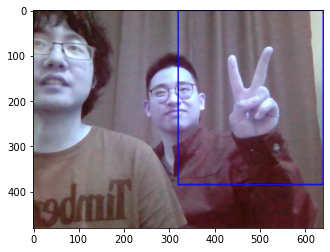

In [43]:
frame = cv2.imread("source/gp.jpg")
plt.imshow(frame)

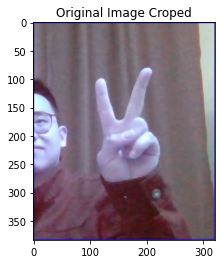

In [44]:
# not gonna to run
# ***********PLEASE DONT RUN THIS**********
# img = removeBG(frame)
img = frame
img = img[0:int(cap_region_y_end * frame.shape[0]),int(cap_region_x_begin * frame.shape[1]):frame.shape[1]]  
plt.title("Original Image Croped")
plt.imshow(img)

# Level Set Method
Contours can be implicitly represented using level sets. Basically, level sets method intersects a plane on the surface and gives us a contour. Different from the limitation of Snakes method, level sets method has the advantages that No extra care is needed for topology change, like merging and splitting. Merging and splitting are handled naturally by the surface motion. In addition, by using the level set, we only calculate energy in a small neighborhood of the object contour.
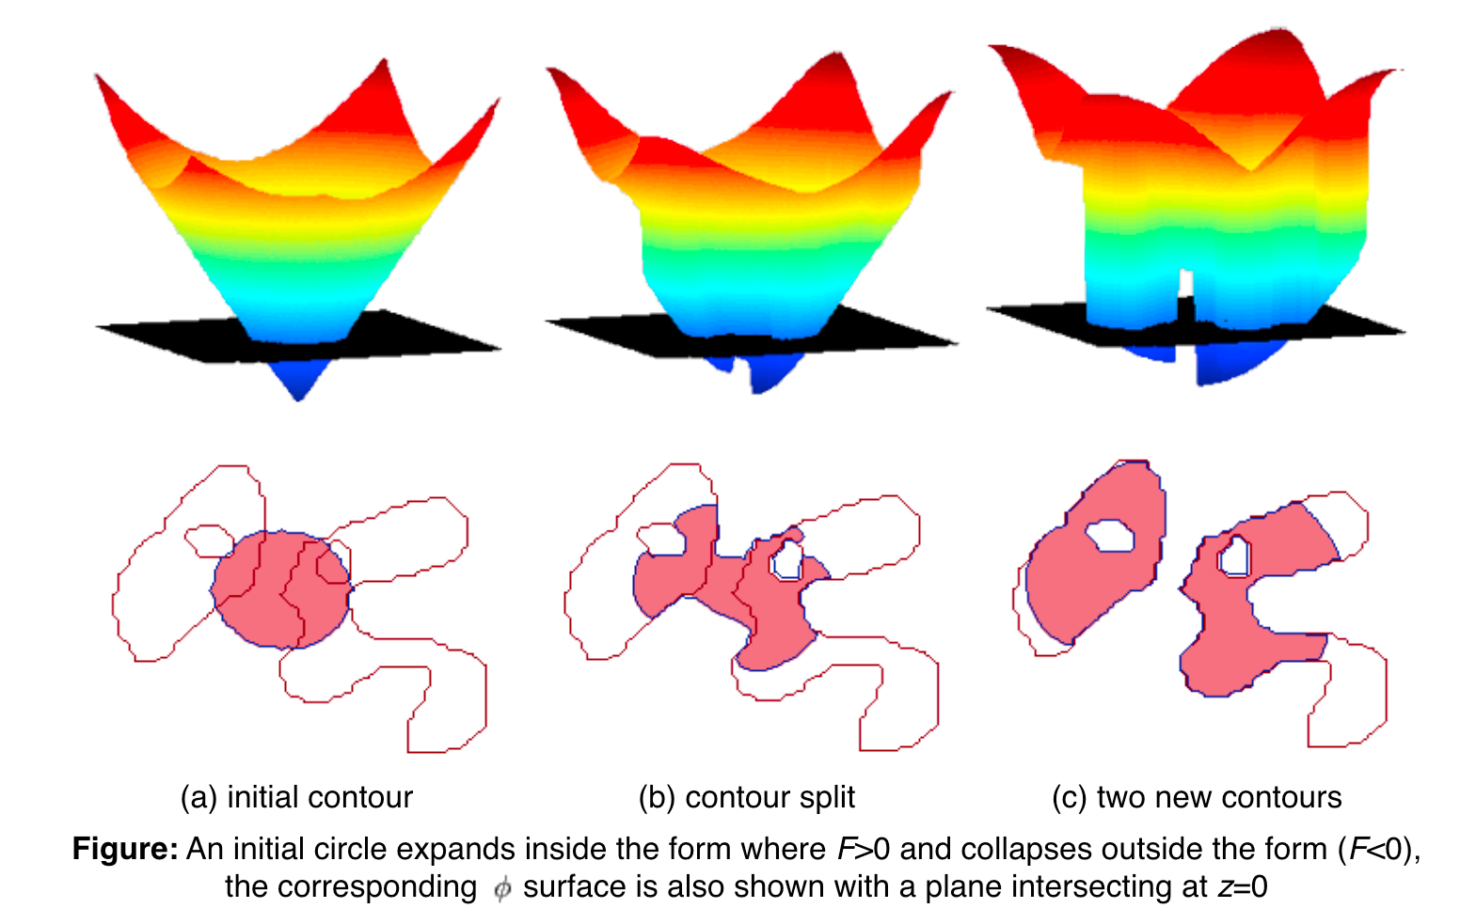
In lecture, we have learned that the evolution equation for the embedding function is: $\newline$
    $$ F\|\nabla \phi\|+\phi_{t}=0 $$ $\newline$
    By solving the PDE, according to Agustinus Kristiadi's Blog, the update function is: $\newline$
    $$ \phi^{\prime}=\phi+\Delta t F\|\nabla \phi\|$$ $\newline$
    $F$ is intuitively a force that drive curve propagation. In other words, we could think of $F$ as a velocity field, i.e. $F$ is a vector field where at every point it tells us the direction and magnitude of movement of our surface $\phi$. $\newline$
    As $F$ is a velocity field and consider the Level Set PDE above, we want $F$ to be high at all region that are not the border of the object we want to segment, and low otherwise. Intuitively, we want the curve to propagate quickly in the background of the image, and we want the curve to slowly propagate or even stop the propagation at the border of the object.
    One way to do it is obviously derive our $F$ from edge detector. Simplest way to do edge detection is to take the gradients of the image: $\newline$
    $$
    g(I)=\frac{1}{1+\|\nabla I\|^{2}}
    $$

## Extract hand by Applying Level Set without Background removal

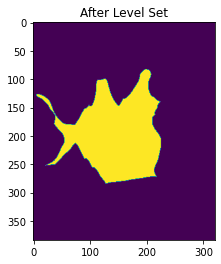

In [35]:
l = lsk2.levelSetSolver(1, 1, 200, False)
l.run(blur)
plt.title('After Level Set')
plt.imshow(l.phi < 0.5)
thresh = ((l.phi < 0.5)*255).astype("uint8")

# Remove Background Method
## --By using cv2 createBackgroundSubtractorMOG2
Simply keep tracking the image stream from camera and check the difference between captured image and current image. Pixils at same position but has difference less than threshold will be considered as background. Then generate a mask and use bitwise and to remove the background.

In [24]:
bgModel = cv2.createBackgroundSubtractorMOG2(0, bgSubThreshold)
frame = img

In [38]:
def removeBG(frame): 
    fgmask = bgModel.apply(frame, learningRate=learningRate) 
    kernel = np.ones((3, 3), np.uint8)
    fgmask = cv2.erode(fgmask, kernel, iterations=1) # erode the image
    res = cv2.bitwise_and(frame, frame, mask=fgmask) # use the mask to remove static background
    return res

In [ ]:
frame = cv2.bilateralFilter(frame, 5, 50, 100) 
frame = cv2.flip(frame, 1) 
cv2.rectangle(frame, (int(cap_region_x_begin * frame.shape[1]), 0),(frame.shape[1], int(cap_region_y_end * frame.shape[0])), (0, 0, 255), 2)
plt.imshow(frame)

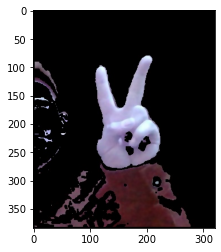

In [45]:
img = cv2.imread("source/backImg.jpg")
plt.imshow(img)

# Applying Gaussian Blur

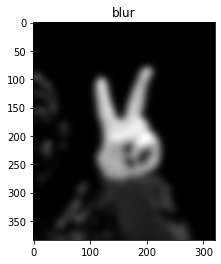

In [41]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # turn the picture to gray scale
blur = cv2.GaussianBlur(gray, (blurValue, blurValue), 0)  # apply gaussian blur
plt.title("blur")
plt.imshow(blur, cmap="gray")

# Applying Level Set Method to extract hand

In [31]:
import source.level_set_kerr_2 as lsk2

# Applying Level Set after Background removal

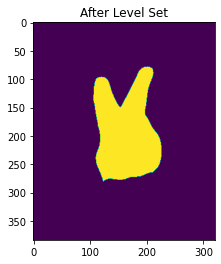

In [48]:
l = lsk2.levelSetSolver(1, 1, 200, False)
l.run(blur)
plt.title('After Level Set')
plt.imshow(l.phi < 0.5)
thresh = ((l.phi < 0.5)*255).astype("uint8")

# Another method: threshold
## -- Faster, but lower performance

## Setting threshold

In [4]:
threshold = 60

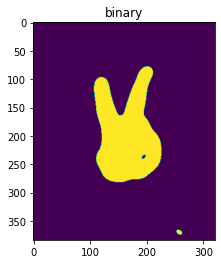

In [11]:
ret, thresh = cv2.threshold(blur, threshold, 255, cv2.THRESH_BINARY) 
plt.title('binary')
plt.imshow(thresh)

In [17]:
# get the coutours
thresh1 = copy.deepcopy(thresh)
contours, hierarchy = cv2.findContours(thresh1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# CV2 FindContour()
## -Border point
## -Soundness among connected component
## -Outer border and Hole Border
## -Parent Border

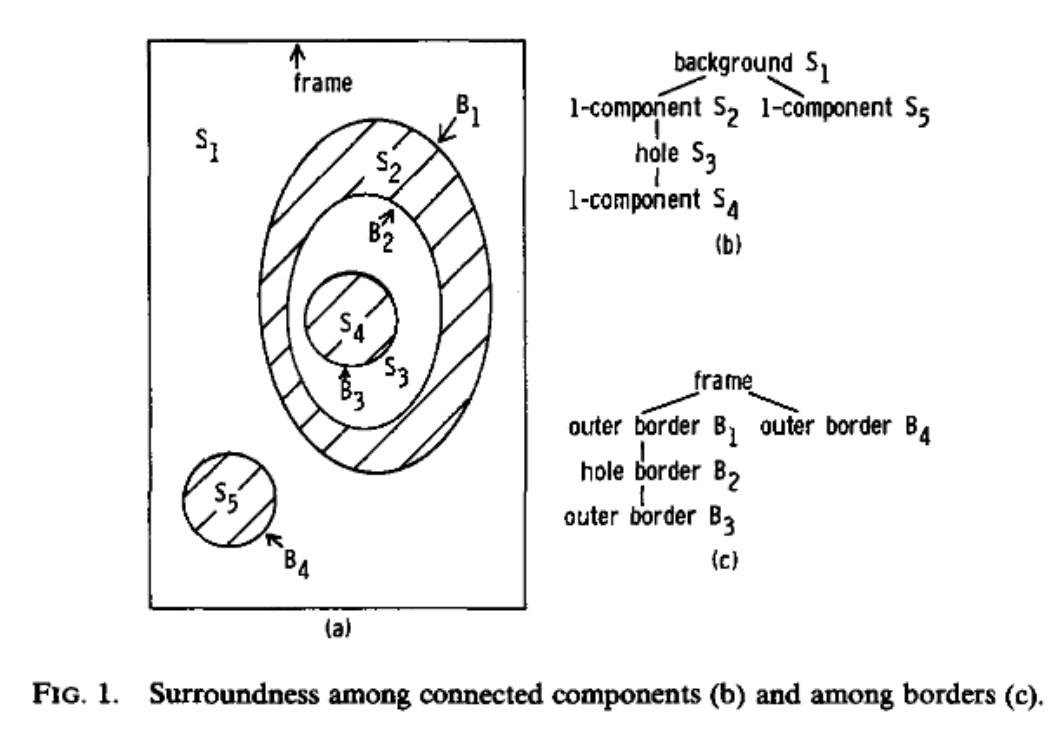

# Count the finger
We used convexhull method to count the number of fingers.

## Convexhull


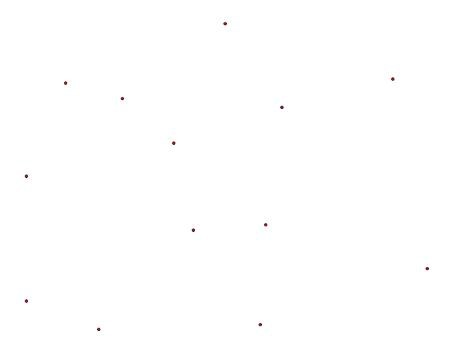

### Using stack to pulling all the data points
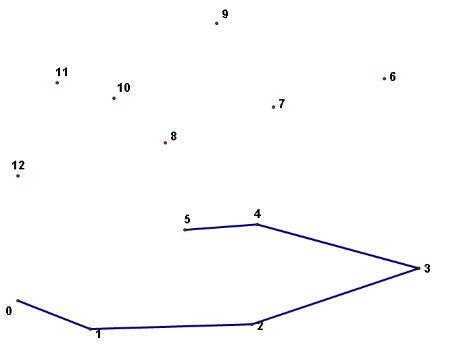

### If the angle formed by the last 3 points are sharp angel, pop out the last data point|
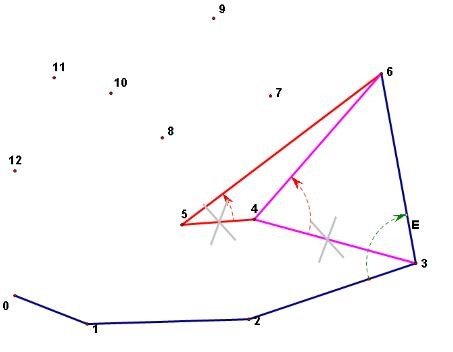

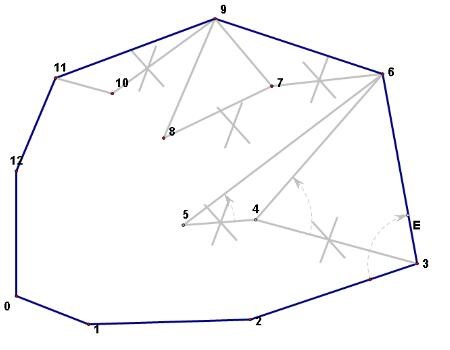

2


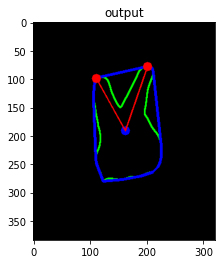

In [18]:
length = len(contours)
maxArea = -1
if length > 0:
    for i in range(length):  # find the largest area
        temp = contours[i]
        area = cv2.contourArea(temp) 
        if area > maxArea:
            maxArea = area
            ci = i

    res = contours[ci]  
    hull = cv2.convexHull(res)  
    drawing = np.zeros(img.shape, np.uint8)
    cv2.drawContours(drawing, [res], 0, (0, 255, 0), 2)   # draw the contour
    cv2.drawContours(drawing, [hull], 0, (0, 0, 255), 3)  # draw the convex

    moments = cv2.moments(res)  
    center = (int(moments['m10'] / moments['m00']), int(moments['m01'] / moments['m00']))
    cv2.circle(drawing, center, 8, (0,0,255), -1)   # draw the center (do not use the lower convex)

    fingerRes = []  
    max = 0; count = 0; notice = 0; cnt = 0
    for i in range(len(res)):
        temp = res[i]
        dist = (temp[0][0] -center[0])*(temp[0][0] -center[0]) + (temp[0][1] -center[1])*(temp[0][1] -center[1])
        if dist > max:
            max = dist
            notice = i
        if dist != max:
            count = count + 1
            if count > 40:
                count = 0
                max = 0
                flag = False 
                if center[1] < res[notice][0][1]: # the direction of hand
                    continue
                for j in range(len(fingerRes)):  # if the two points are too close, get rid of it
                    if abs(res[notice][0][0]-fingerRes[j][0]) < 40 :
                        flag = True
                        break
                if flag :
                    continue
                fingerRes.append(res[notice][0])
                cv2.circle(drawing, tuple(res[notice][0]), 8 , (255, 0, 0), -1) 
                cv2.line(drawing, center, tuple(res[notice][0]), (255, 0, 0), 2)
                cnt = cnt + 1
    plt.clf()
    plt.title("output")
    plt.imshow(drawing, cmap="gray")
    print(cnt)

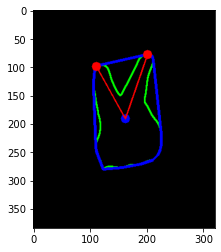

In [53]:
plt.imshow(drawing, cmap="gray")

# Something else...
## Generate random choise

In [49]:
ai = 2
player = frame
ais = ' '
ps = ' '
result = ' '
if ai == 0:
    ais = ' rock'
elif ai == 1:
    ais = ' paper'
elif ai == 2:
    ais = ' sessor'

In [50]:
ais

' sessor'

## Counting number of fingers

In [51]:
if cnt == 1:
    ps='rock'
    if ai == 0:
        result ='Draw'
    elif ai == 1:
        result = 'You Lose'
    elif ai == 2:
        result = 'You win'
elif cnt == 2 or cnt == 3:
    ps='sessor'
    if ai == 2:
        result ='Draw'
    elif ai == 0:
        result = 'You Lose'
    elif ai == 1:
        result = 'You win'
elif cnt >= 4:
    ps='papper'
    if ai == 1:
        result ='Draw'
    elif ai == 2:
        result = 'You Lose'
    elif ai == 0:
        result = 'You win'

## Result

In [52]:
result

'Draw'

# Split works
## Everyone are working together in UCSB Library.
### - Ke(Kerr) Ding and Zeben Wu focused on Image preprocessing
### - Zexi Liu focused on camera api
### - Jiaqi(Jack) Tang focused on counting fingers